In [36]:
import numpy as np
import pandas as pd
from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization

from tqdm.notebook import tqdm_notebook as tqdm

import os

## Preparing training data

In [5]:
data = {}

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
    
        if dirname == "/kaggle/input/cat-and-dog/training_set/training_set/cats" and filename != "_DS_Store":
            data.update({filename:0})
        elif dirname == "/kaggle/input/cat-and-dog/training_set/training_set/dogs" and filename != "_DS_Store":
            data.update({filename:1})
            
data = pd.DataFrame(data.items(), columns=["Filename","Class"])

In [6]:
data.head()

,Filename,Class
0,dog.3297.jpg,1
1,dog.462.jpg,1
2,dog.3380.jpg,1
3,dog.3403.jpg,1
4,dog.2399.jpg,1


In [7]:
data.tail()

,Filename,Class
8000,cat.3669.jpg,0
8001,cat.2859.jpg,0
8002,cat.963.jpg,0
8003,cat.137.jpg,0
8004,cat.3737.jpg,0


In [13]:
print("The shape of the data:",data.shape)
print("\nThe number of different classes: \n\n",data.groupby('Class').count())

The shape of the data: (8005, 2)

The number of different classes: 

        Filename
Class          
0          4000
1          4005


## Visualization

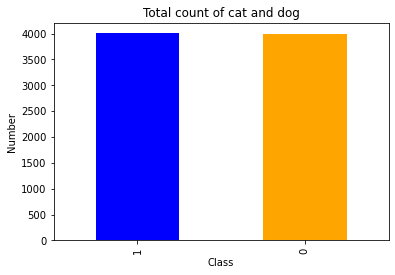

In [25]:
data['Class'].value_counts().plot.bar(color=["blue","orange"])

plt.title("Total count of cat and dog")
plt.ylabel('Number')
plt.xlabel('Class')
plt.show()

## Sample image

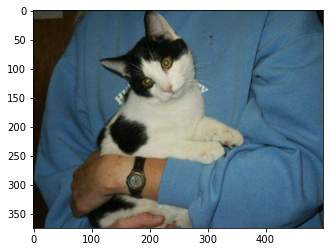

In [33]:
image = load_img("../input/cat-and-dog/training_set/training_set/cats/cat.1018.jpg")
plt.imshow(image)
plt.show()

## Converting the images into array

In [34]:
images = []

for dirname, _, filenames in os.walk('../input/cat-and-dog/training_set/training_set'):
    for filename in filenames:
        if filename != "_DS_Store":
            images.append(os.path.join(dirname, filename))
            
print("Total number of images:",len(images))

Total number of images: 8005


In [35]:
IMAGE_SIZE = 128

from PIL import Image
batch_images = np.zeros((len(data["Class"]), IMAGE_SIZE, IMAGE_SIZE,3), dtype=np.float32)

for i, f in tqdm(enumerate(images)):
  #print(f)
  img = Image.open(f)
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  img = img.convert('RGB')
  batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

y = data["Class"]
y = np.array(y)

## Splitting the data into Train and Test

In [37]:
Xtrain, Xtest, ytrain, ytest = train_test_split(batch_images, y, test_size = 0.20)

## Building and compiling of the Model

In [39]:
mnet = MobileNetV2(include_top = False, pooling="max", weights = "imagenet" ,input_shape=(128,128,3))

def create_model():
  tf.keras.backend.clear_session()
  model = Sequential([mnet,
                      Dropout(0.5),
                      #Dense(128, activation = "relu"),
                      Dense(1, activation = "sigmoid")])
  
  model.layers[0].trainable = False
  model.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")

  return model

model = create_model()

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


## Callbacks

In [41]:
#We will reduce the learning rate when then accuracy not increase for 2 steps

reduce_lr = ReduceLROnPlateau(monitor='val_iou',factor=0.2,patience=2, min_lr=1e-7, verbose=1, mode="max" )

In [44]:
#To prevent over fitting we will stop the learning after 3 epochs and val_loss value not decreased

stop = EarlyStopping(monitor='val_iou', patience=3, mode="max" )

### Training the model

In [43]:
history = model.fit(Xtrain, ytrain, epochs=10,callbacks=[stop,reduce_lr], verbose = 2, validation_data=(Xtest,ytest))

Epoch 1/10
201/201 - 4s - loss: 0.3410 - accuracy: 0.8993 - val_loss: 0.1241 - val_accuracy: 0.9606
Epoch 2/10
201/201 - 3s - loss: 0.1796 - accuracy: 0.9493 - val_loss: 0.1153 - val_accuracy: 0.9681
Epoch 3/10
201/201 - 3s - loss: 0.1497 - accuracy: 0.9550 - val_loss: 0.1091 - val_accuracy: 0.9700
Epoch 4/10
201/201 - 3s - loss: 0.1321 - accuracy: 0.9627 - val_loss: 0.1042 - val_accuracy: 0.9713
Epoch 5/10
201/201 - 3s - loss: 0.1116 - accuracy: 0.9666 - val_loss: 0.1055 - val_accuracy: 0.9681
Epoch 6/10
201/201 - 3s - loss: 0.1085 - accuracy: 0.9655 - val_loss: 0.0947 - val_accuracy: 0.9706
Epoch 7/10
201/201 - 3s - loss: 0.0917 - accuracy: 0.9705 - val_loss: 0.1078 - val_accuracy: 0.9669
Epoch 8/10
201/201 - 3s - loss: 0.0953 - accuracy: 0.9688 - val_loss: 0.0939 - val_accuracy: 0.9706
Epoch 9/10
201/201 - 3s - loss: 0.0931 - accuracy: 0.9692 - val_loss: 0.1456 - val_accuracy: 0.9563
Epoch 10/10
201/201 - 3s - loss: 0.0975 - accuracy: 0.9700 - val_loss: 0.1105 - val_accuracy: 0.9669

## Visulazing the training

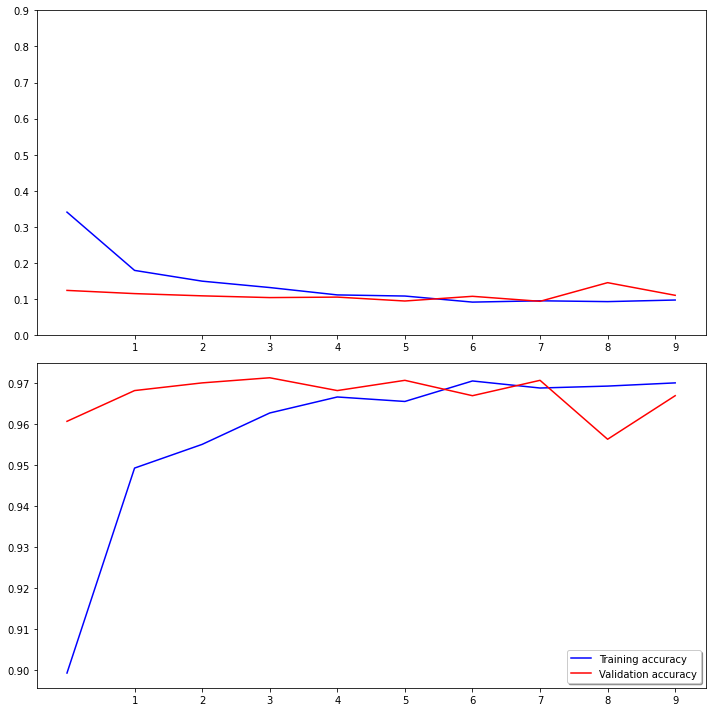

In [52]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 10, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 10, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

### Predicting the test images

In [54]:
#Creating an array of predicted test images

predictions = model.predict(Xtest)

### Visualising the predicted images

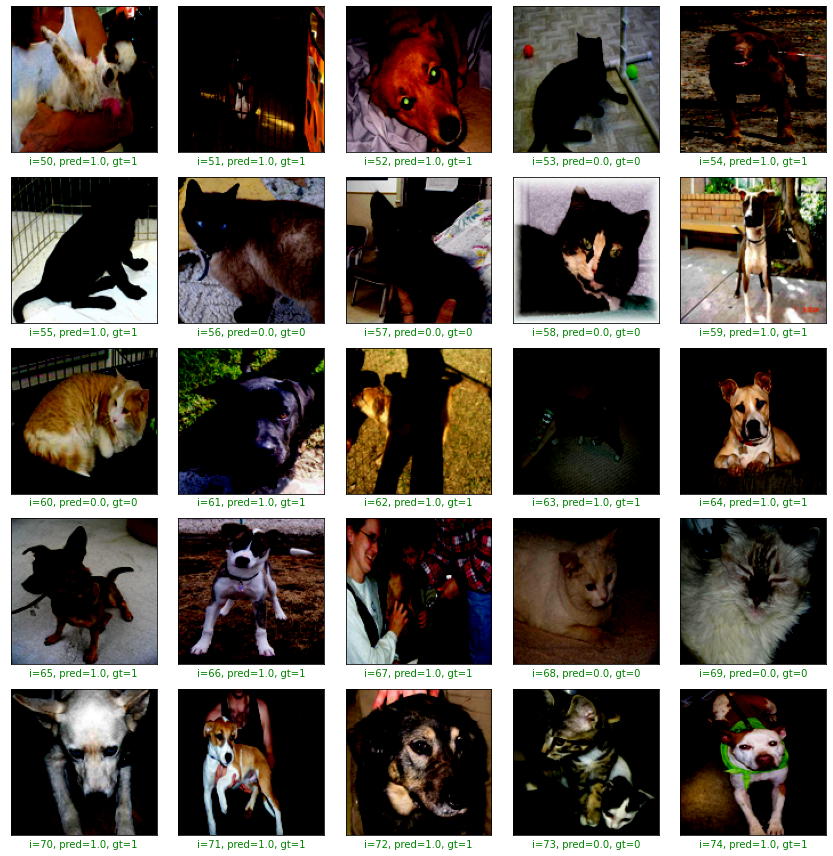

In [58]:
plt.figure(figsize=(12,12))

start_index = 50

for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  preds = np.round(np.squeeze([predictions[start_index+i]]))
  gt = ytest[start_index+i]

  col = "g"
  if preds != gt:
    col ="r"

  plt.xlabel('i={}, pred={}, gt={}'.format(start_index+i,preds,gt),color=col)
  plt.imshow(Xtest[start_index+i], cmap="binary")
  plt.tight_layout()

plt.show()